# SparK: Visualization for "mask pattern vanishing" issue
Load binary images and visualize the convoluted images.

In [1]:
# load images

import torch
from torchvision.io import read_image

N = 3
raw_inp = []
for i in range(1, N+1):
    chw = read_image(f'viz_imgs/spconv{i}.png')[:1] # only take the first channel
    BLACK = 0
    # binarize: black represents active (1), white represents masked (0)
    active = torch.where(chw == BLACK, torch.ones_like(chw, dtype=torch.float) * 255., torch.zeros_like(chw, dtype=torch.float))
    raw_inp.append(active)
raw_inp = torch.stack(raw_inp, dim=0)
active = raw_inp.bool()     # active: 1, masked: 0

In [2]:
# apply dense conv and sparse conv

import encoder
dense_conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), stride=1, padding=1, bias=False)
sparse_conv = encoder.SparseConv2d(1, 1, kernel_size=(3, 3), stride=1, padding=1, bias=False)

dense_conv.weight.data.fill_(1/dense_conv.weight.numel()), dense_conv.weight.requires_grad_(False)
sparse_conv.weight.data.fill_(1/sparse_conv.weight.numel()), sparse_conv.weight.requires_grad_(False)

# after the first dense conv
conv1 = (dense_conv(raw_inp) > 0) * 255.    # binarize
# after the second dense conv
conv2 = (dense_conv(conv1) > 0) * 255.      # binarize

# after the sparse conv
encoder._cur_active = active
spconv = (sparse_conv(raw_inp) > 0) * 255.  # binarize

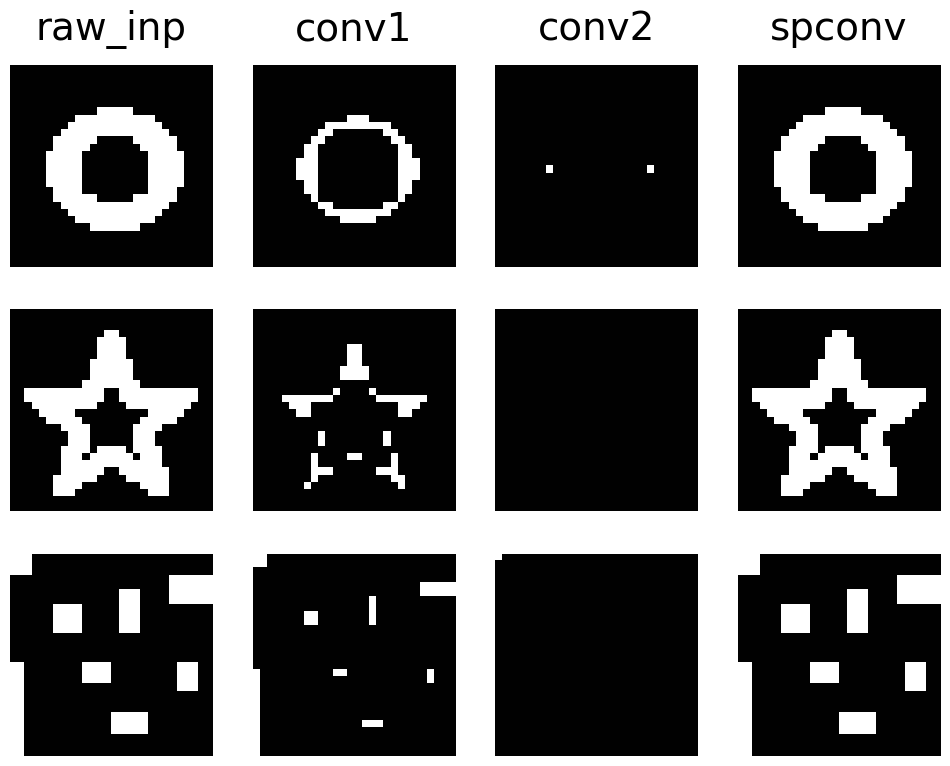

In [3]:
# visualization

from typing import List
import PIL.Image as PImage
import matplotlib.pyplot as plt
from torchvision import transforms

raw_inps, conv1s, conv2s, spconvs = [], [], [], []
for i in range(N):
    raw_inps.append(raw_inp[i].repeat(3, 1, 1).clamp(1, 255))
    conv1s.append(conv1[i].repeat(3, 1, 1).clamp(1, 255))
    conv2s.append(conv2[i].repeat(3, 1, 1).clamp(1, 255))
    spconvs.append(spconv[i].repeat(3, 1, 1).clamp(1, 255))

n_rows, n_cols = N, 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))

tensor2pil = transforms.ToPILImage()
for col, (title, chws) in enumerate([('raw_inp', raw_inps), ('conv1', conv1s), ('conv2', conv2s), ('spconv', spconvs)]):
    p_imgs: List[PImage.Image] = [tensor2pil(t).convert('RGB') for t in chws]
    for row, im in enumerate(p_imgs):
        plt.subplot(n_rows, n_cols, 1 + row * n_cols + col)
        plt.xticks([]), plt.yticks([]), plt.axis('off')
        plt.imshow(im)
        if row == 0:
            plt.title(title, size=28, pad=18)
plt.show()
